In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl
import os

In [7]:
import pytorch_lightning as pl
help(pl.Trainer)

Help on class Trainer in module pytorch_lightning.trainer.trainer:

class Trainer(pytorch_lightning.trainer.properties.TrainerProperties, pytorch_lightning.trainer.callback_hook.TrainerCallbackHookMixin, pytorch_lightning.trainer.model_hooks.TrainerModelHooksMixin, pytorch_lightning.trainer.optimizers.TrainerOptimizersMixin, pytorch_lightning.trainer.logging.TrainerLoggingMixin, pytorch_lightning.trainer.training_tricks.TrainerTrainingTricksMixin, pytorch_lightning.trainer.data_loading.TrainerDataLoadingMixin, pytorch_lightning.trainer.deprecated_api.DeprecatedDistDeviceAttributes, pytorch_lightning.trainer.deprecated_api.DeprecatedTrainerAttributes)
 |  Trainer(logger: Union[pytorch_lightning.loggers.base.LightningLoggerBase, Iterable[pytorch_lightning.loggers.base.LightningLoggerBase], bool] = True, checkpoint_callback: bool = True, callbacks: Union[List[pytorch_lightning.callbacks.base.Callback], pytorch_lightning.callbacks.base.Callback, NoneType] = None, default_root_dir: Union[st

In [61]:
import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)

In [3]:
def AzZe_target_constructor(dataset, transformer):
    az_ze = dataset.data.y.view(-1,10,1)[:,[8,9]]
    tfs = transformer
    
    az = torch.tensor(tfs['truth']['azimuth'].inverse_transform(az_ze[:,0]),dtype=torch.float)
    ze = torch.tensor(tfs['truth']['zenith'].inverse_transform(az_ze[:,1]),dtype=torch.float) #the range seems to be about [0,pi/2]?. Makes sense, Muons come from the atmosphere
    
    dataset.data.y = torch.cat([az,ze],dim=1).flatten()
    dataset.slices['y'] = np.arange(0,len(dataset.data.y)+1, 2)
    return dataset

In [4]:
path = "C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets"
filename = "muon_100k_set11_SRT.pt"
transformer = pd.read_pickle(path + "/transformers.pkl")

batch_size = 512

dataset, train_loader, test_loader, val_loader = fc.dataset_preparator(name = filename,
                                                                       path = path,
                                                                       transformer = transformer,
                                                                       tc = AzZe_target_constructor,
                                                                       fc = fc.custom_feature_constructor,
                                                                       shuffle = True,
                                                                       TrTV_split = (0.9,0.9,1),
                                                                       batch_size = batch_size)

2021-02-22 11:00:39.782510: loading data..
2021-02-22 11:00:39.922462: executing target constructor..
2021-02-22 11:00:39.927459: executing feature constructor..
2021-02-22 11:00:47.891493: shuffling dataset..
2021-02-22 11:00:47.919482: defining dataloaders..
2021-02-22 11:00:47.920482: Done!


In [62]:
import Model_tmp as M
M = importlib.reload(M)

run_name = 'Test run - delete me'

args = {'N_edge_feats': 6,
        'N_dom_feats': 5,
        'N_targets': 3,
        'N_metalayers': 5,
        'N_hcs': 16,
        'wandb_activated': True,
        'lr': 1e-3,
        'batch_size': batch_size}

model = M.Load_model('Spherical_NLLH',args)

Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [63]:
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(monitor='Val Acc', 
                                                                min_delta=0.00, 
                                                                patience=3, 
                                                                verbose=False, 
                                                                mode='min')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath = os.getcwd()+'\\checkpoints',
                                                   filename = '{epoch}-{Val Acc:.3f}',
                                                   save_top_k = 1,
                                                   verbose = True,
                                                   monitor = 'Val Acc',
                                                   mode = 'min',
                                                   prefix = run_name)

lr_logger = pl.callbacks.lr_monitor.LearningRateMonitor(logging_interval = 'epoch')

from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name = run_name,
                           project = 'Neutrino-Machine-Learning')

trainer = pl.Trainer(gpus=1, #-1 for all gpus
                     max_epochs=5,
                     auto_lr_find = True,
                     log_every_n_steps = 5,
                     callbacks=[early_stop_callback, checkpoint_callback, lr_logger], 
                     logger = wandb_logger if args['wandb_activated'] else False)

# if args['wandb_activated']:
#     wandb_logger.watch(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [53]:
lr_finder = trainer.tuner.lr_find(model,train_loader,num_training=500,early_stop_threshold=4)


C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name              | Type       | Params
-------------------------------------------------
0 | act               | SiLU       | 0     
1 | x_encoder         | Linear     | 480   
2 | edge_attr_encoder | Linear     | 112   
3 | u_encoder         | Linear     | 1.9 K 
4 | ops               | ModuleList | 399 K 
5 | decoders          | ModuleList | 75.4 K
6 | decoder           | Linear     | 99    
-------------------------------------------------
477 K     Trainable params
0         Non-trainable params
477 K     Total params
1.908     Total estimated model params size (MB)


LR finder stopped early due to diverging loss.


Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\lr_find_temp_model.ckpt


In [5]:
import pytorch_lightning as pl
help(pl.Trainer)

Help on class Trainer in module pytorch_lightning.trainer.trainer:

class Trainer(pytorch_lightning.trainer.properties.TrainerProperties, pytorch_lightning.trainer.callback_hook.TrainerCallbackHookMixin, pytorch_lightning.trainer.model_hooks.TrainerModelHooksMixin, pytorch_lightning.trainer.optimizers.TrainerOptimizersMixin, pytorch_lightning.trainer.logging.TrainerLoggingMixin, pytorch_lightning.trainer.training_tricks.TrainerTrainingTricksMixin, pytorch_lightning.trainer.data_loading.TrainerDataLoadingMixin, pytorch_lightning.trainer.deprecated_api.DeprecatedDistDeviceAttributes, pytorch_lightning.trainer.deprecated_api.DeprecatedTrainerAttributes)
 |  Trainer(logger: Union[pytorch_lightning.loggers.base.LightningLoggerBase, Iterable[pytorch_lightning.loggers.base.LightningLoggerBase], bool] = True, checkpoint_callback: bool = True, callbacks: Union[List[pytorch_lightning.callbacks.base.Callback], pytorch_lightning.callbacks.base.Callback, NoneType] = None, default_root_dir: Union[st

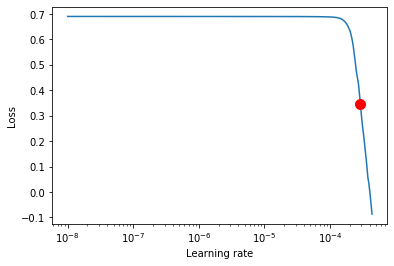

0.0002910717118066608


In [54]:
fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

In [64]:
model.lr = lr_finder.suggestion()

In [67]:
trainer.fit(model, train_loader, val_loader)


  | Name              | Type       | Params
-------------------------------------------------
0 | act               | SiLU       | 0     
1 | x_encoder         | Linear     | 480   
2 | edge_attr_encoder | Linear     | 112   
3 | u_encoder         | Linear     | 1.9 K 
4 | ops               | ModuleList | 399 K 
5 | decoders          | ModuleList | 75.4 K
6 | decoder           | Linear     | 99    
-------------------------------------------------
477 K     Trainable params
0         Non-trainable params
477 K     Total params
1.908     Total estimated model params size (MB)


Im here now!


Epoch 4, global step 1231: Val Acc reached -0.04927 (best -0.04927), saving model to "C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\checkpoints\Test run - delete me-epoch=4-Val Acc=-0.049.ckpt" as top 1


Im here now!


1

In [68]:
wandb.finish()

lr-Adam,1e-05
_runtime,744
_timestamp,1613991418
_step,2110
Train Loss,-474.84387
Train Acc,-0.04381
epoch,4
Val Acc2,-0.04927
Val Acc,-0.04927


lr-Adam,▁▂█▇▇▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▇▇▇▇▇▇█████
Train Loss,██████████████████████▇▆█████████▇▆▅▂▂▁▁
Train Acc,██▇█▇██▇▄▃▄▃▃▆▃▄▃▃▄▄▃▃▂▃▄▄▃▄▃▃▃▃▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████████████████
Val Acc2,█▄▄▄▃▂▁
Val Acc,█▄▄▄▃▂▁


In [22]:
filename = "muon_100k_set12_SRT.pt"
dataset, train_loader, test_loader, val_loader = fc.dataset_preparator(name = filename,
                                                                       path = path,
                                                                       transformer = transformer,
                                                                       tc = AzZe_target_constructor,
                                                                       fc = fc.custom_feature_constructor,
                                                                       shuffle = True,
                                                                       TrTV_split = (0,1,1),
                                                                       batch_size = args['batch_size'])

2021-02-19 13:58:07.486523: loading data..
2021-02-19 13:58:08.846916: executing target constructor..
2021-02-19 13:58:08.858912: executing feature constructor..
2021-02-19 13:58:17.235923: shuffling dataset..
2021-02-19 13:58:17.274909: defining dataloaders..
2021-02-19 13:58:17.275909: Done!


In [25]:
trainer.test(model,test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test Acc': nan}
--------------------------------------------------------------------------------


C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'Test Acc': nan}]